In [11]:
from modules.episodic_prototypical import PrototypicalNetworks
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.models import resnet18
from fewshot_sampler import FewShotSampler
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path
from wrap_few_shot_dataset import WrapFewShotDataset

def get_labels(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    class_ids: torch.Tensor
):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """

    predicted_tensor = torch.max(
            model(support_images, support_labels, query_images)
            .detach()
            .data,
            1,
        )[1].tolist()
    
    pred_labels = []
    class_labels = []

    for i, label in enumerate(query_labels):
        pred_labels.append(class_ids[predicted_tensor[i]])
        class_labels.append(class_ids[label])

    return pred_labels, class_labels


def get_data(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    pred = []
    true = []

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()

    with torch.no_grad():
        for (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(data_loader, total=len(data_loader)):

            correct, total = get_labels(
                support_images, support_labels, query_images, query_labels, class_ids
            )

            pred.extend(correct)
            true.extend(total)

    return pred, true


if __name__ == "__main__":

    image_size = 28

    # Setup path to data folder
    data_path = Path("data")
    image_path = data_path / "UCMerced"

    # Check if image folder exists
    if image_path.is_dir():
        print(f"{image_path} directory exists.")
    else:
        print(f"Did not find {image_path} directory")
        exit()

    # Setup train and testing paths
    test_dir = image_path / "Test1"

    test_transform = transforms.Compose([
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])

    test_set = datasets.ImageFolder(
        root=test_dir,
        transform=test_transform,
    )

    test_set = WrapFewShotDataset(test_set)

    convolutional_network = resnet18(pretrained=True)
    convolutional_network.fc = nn.Flatten()
    model = PrototypicalNetworks(convolutional_network)
    model.load_state_dict(torch.load("models/fewshot_merced_proto_res18_corrected.pth",map_location=torch.device('cuda')))


    N_WAY = 5  # Number of classes in a task
    N_SHOT =5  # Number of images per class in the support set
    N_QUERY = 10  # Number of images per class in the query set
    N_EVALUATION_TASKS = 100

    test_sampler = FewShotSampler (
        test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
    )

    test_loader = DataLoader(
        test_set,
        batch_sampler=test_sampler,
        num_workers=8,
        pin_memory=True,
        collate_fn=test_sampler.episodic_collate_fn,
    )

    model.eval()
    pred, true = get_data(test_loader)

data/UCMerced directory exists.


Scrolling dataset's labels...: 100%|██████████| 500/500 [00:00<00:00, 584.92it/s]
/home/eileen/miniconda3/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eileen/miniconda3/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


[[462   0  10   0   0   3   0   0   5   0]
 [  0 444   4   0   3   2  12   0   2   3]
 [ 26   5 253  15  41  50   4  14  28  44]
 [  0   0   4 544   1   0   0   0   0   1]
 [  6   3  55   6 296  31  13  32  27  41]
 [  8   5  36   1  21 444   0   2  10   3]
 [  2   2   7   2   8   0 371   8  36  24]
 [  0   0   3   0  14   0   1 440   5   7]
 [ 45   1  35  20  28  26  20  28 276  71]
 [ 19   1  43  12  73   6  20  23  51 252]]


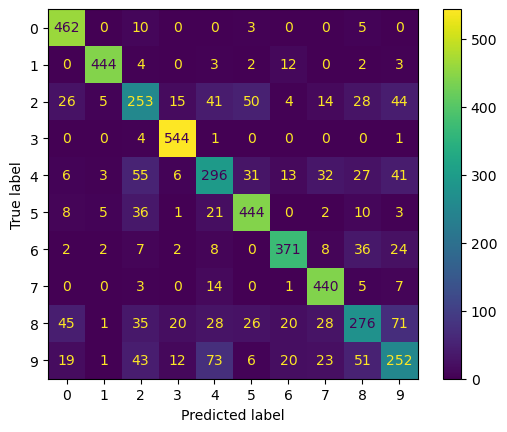

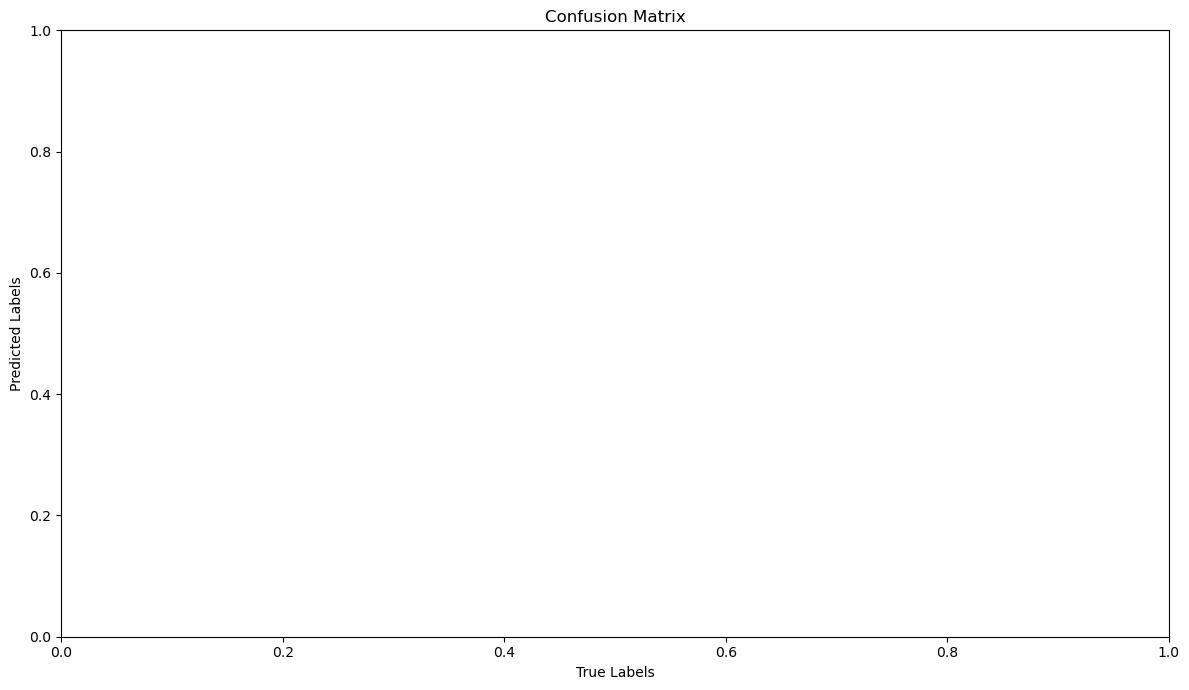

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# generate confusion matrix
classes = ('buildings', 'denseresidential', 'mediumresidential',
    'mobilehomepark', 'storagetanks')

cf_matrix = confusion_matrix(true,pred)
print(cf_matrix)
# df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                  columns = [i for i in classes])

# ConfusionMatrixDisplay(cf_matrix).plot()

df_cm = ConfusionMatrixDisplay(cf_matrix).plot()

plt.figure(figsize = (12,7))
# sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.tight_layout()
plt.savefig('fewshot_confusion.png')

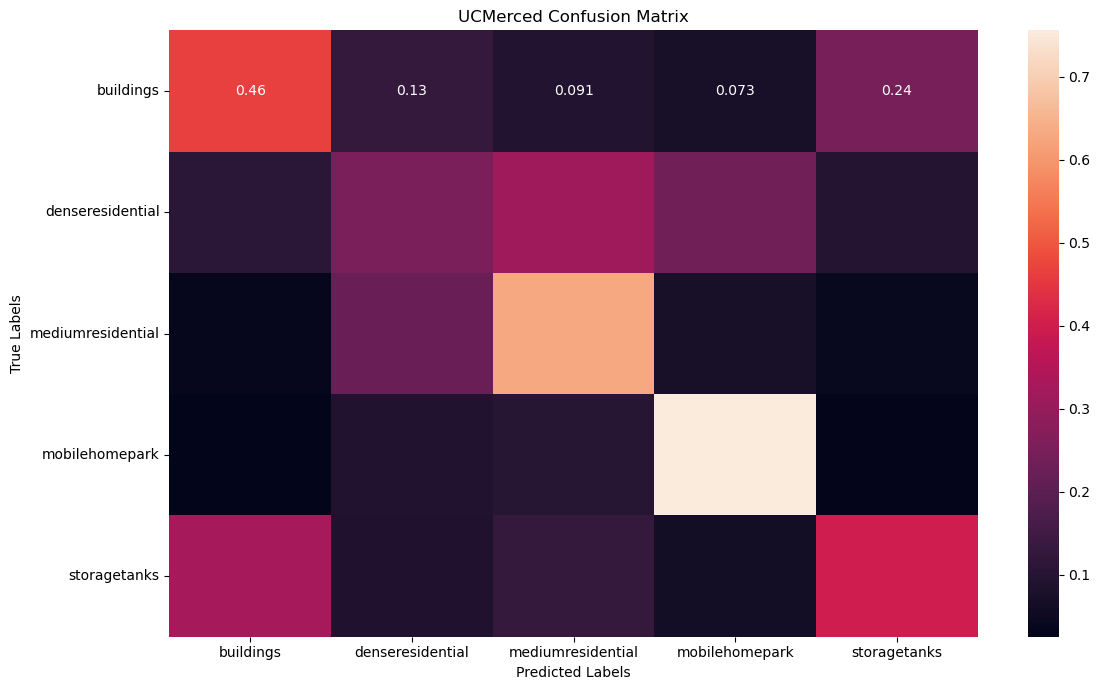

In [12]:
 # generate confusion matrix
# classes = ('buildings', 'chaparral', 'denseresidential', 'intersection', 'mediumresidential',
#     'mobilehomepark', 'river', 'sparseresidential', 'storagetanks', 'tenniscourt')
# classes = ('AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake')
classes = classes = ('buildings', 'denseresidential', 'mediumresidential',
    'mobilehomepark', 'storagetanks')

cf_matrix = confusion_matrix(true,pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                    columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.title("UCMerced Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.savefig('confusion_matrices/UCMerced_hard.png')